# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import struct
from scipy.io import wavfile as wav
from IPython.display import Image
import matplotlib.pyplot as plt

# MetaData

In [2]:
meta_data = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
print(meta_data.shape)
meta_data.head()

(8732, 8)


slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [4]:
data_description = []
for i in range(1,11):
    data_description.append(meta_data[meta_data.fold == i]['class'].value_counts())
    
data_description = pd.DataFrame(data_description)
data_description['folder'] = ["fold"+str(x) for x in range(1,11)]
data_description.reset_index(inplace = True)
data_description

index  air_conditioner  car_horn  children_playing  dog_bark  drilling  \
0  class              100        36               100       100       100   
1  class              100        42               100       100       100   
2  class              100        43               100       100       100   
3  class              100        59               100       100       100   
4  class              100        98               100       100       100   
5  class              100        28               100       100       100   
6  class              100        28               100       100       100   
7  class              100        30               100       100       100   
8  class              100        32               100       100       100   
9  class              100        33               100       100       100   

   engine_idling  gun_shot  jackhammer  siren  street_music  folder  
0             96        35         120     86           100   fold1  
1            100        35         120     91           100   fold2  
2            107        36         120    119           100   fold3  
3            107        38         120    166           100   fold4  
4            107        40         120     71           100   fold5  
5            107        46          68     74           100   fold6  
6            106        51          76     77           100   fold7  
7             88        30          78     80           100   fold8  
8             89        31          82     82           100   fold9  
9             93        32          96     83           100  fold10

In [5]:
meta_data['class'].value_counts()

dog_bark            1000
air_conditioner     1000
jackhammer          1000
drilling            1000
children_playing    1000
street_music        1000
engine_idling       1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

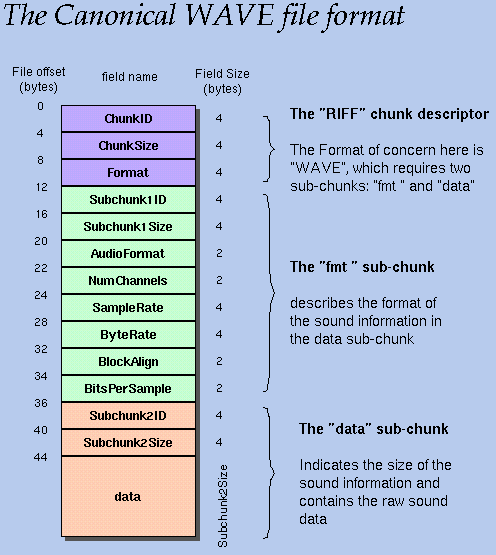

In [6]:
Image(filename='wav-sound-format.png') 

In [9]:
def get_path_and_class(file_name):
    row = meta_data[meta_data['slice_file_name'] == file_name]
    file_path = os.path.join('UrbanSound8K/audio', 'fold'+str(row.fold.values[0]), file_name)
    return file_path, row['class'].values[0]

def get_channel_sampling_rate_and_bit_depth(file_name):
    file_path, _ = get_path_and_class(file_name)
    wave_file = open(file_path,"rb")
    riff = wave_file.read(36)
    no_channels_string = riff[22:24]
    no_channels = struct.unpack("H",no_channels_string)[0]
    sampling_rate_string = riff[24:28]
    sampling_rate = struct.unpack("I",sampling_rate_string)[0]
    bit_depth_string = riff[34:36]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    return (no_channels, sampling_rate, bit_depth)

In [11]:
more_data = [get_channel_sampling_rate_and_bit_depth(i) for i in meta_data.slice_file_name]

In [14]:
meta_data[['no_channels','sampling_rate','bit_depth']] = pd.DataFrame(more_data)
meta_data.head(10)

slice_file_name    fsID      start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032   0.000000   0.317551         1     5        3   
1  100263-2-0-117.wav  100263  58.500000  62.500000         1     5        2   
2  100263-2-0-121.wav  100263  60.500000  64.500000         1     5        2   
3  100263-2-0-126.wav  100263  63.000000  67.000000         1     5        2   
4  100263-2-0-137.wav  100263  68.500000  72.500000         1     5        2   
5  100263-2-0-143.wav  100263  71.500000  75.500000         1     5        2   
6  100263-2-0-161.wav  100263  80.500000  84.500000         1     5        2   
7    100263-2-0-3.wav  100263   1.500000   5.500000         1     5        2   
8   100263-2-0-36.wav  100263  18.000000  22.000000         1     5        2   
9    100648-1-0-0.wav  100648   4.823402   5.471927         2    10        1   

              class  sampling_rate  no_channels  bit_depth  
0          dog_bark          44100            2         16  
1  children_playing          44100            2         16  
2  children_playing          44100            2         16  
3  children_playing          44100            2         16  
4  children_playing          44100            2         16  
5  children_playing          44100            2         16  
6  children_playing          44100            2         16  
7  children_playing          44100            2         16  
8  children_playing          44100            2         16  
9          car_horn          44100            2         16

In [15]:
meta_data.sampling_rate.value_counts()

44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4
Name: sampling_rate, dtype: int64

In [17]:
meta_data.no_channels.value_counts()

2    7993
1     739
Name: no_channels, dtype: int64

In [18]:
meta_data.bit_depth.value_counts()

16    5758
24    2753
32     169
8       43
4        9
Name: bit_depth, dtype: int64

# Librosa

By default, Librosa will convert the sampling rate to 22.05khz, as well as reducing the number of channels to 1(mono), and normalize the data so
that the values will range from -1 to 1.

In [19]:
import librosa

In [21]:
file_path,_ = get_path_and_class('100652-3-0-1.wav')
librosa_load, librosa_sampling_rate = librosa.load(file_path)
scipy_sampling_rate, scipy_load = wav.read(file_path)
print('original wav file min - max range:',np.min(scipy_load),'-',np.max(scipy_load))
print('converted wav file min - max range:',np.min(librosa_load),'-',np.max(librosa_load))
print('\n')
print('original sample rate:',scipy_sampling_rate)
print('converted sample rate:',librosa_sampling_rate)

original wav file min - max range: -30926 - 30119
converted wav file min - max range: -0.729611 - 0.743313


original sample rate: 44100
converted sample rate: 22050


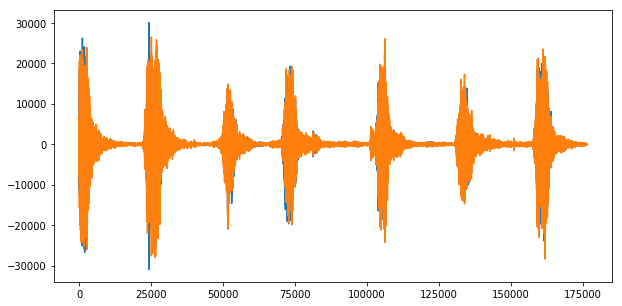

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(scipy_load)
plt.show()

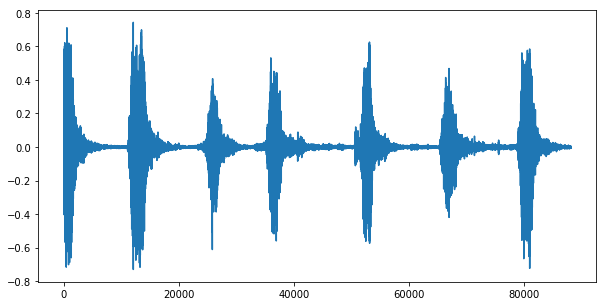

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(librosa_load)
plt.show()

# Visualization

In [33]:
from matplotlib.pyplot import specgram
from librosa.display import waveplot, specshow


def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load('UrbanSound8k\\audio\\fold1\\' + fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 1: Waveplot",x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60))
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 2: Spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()



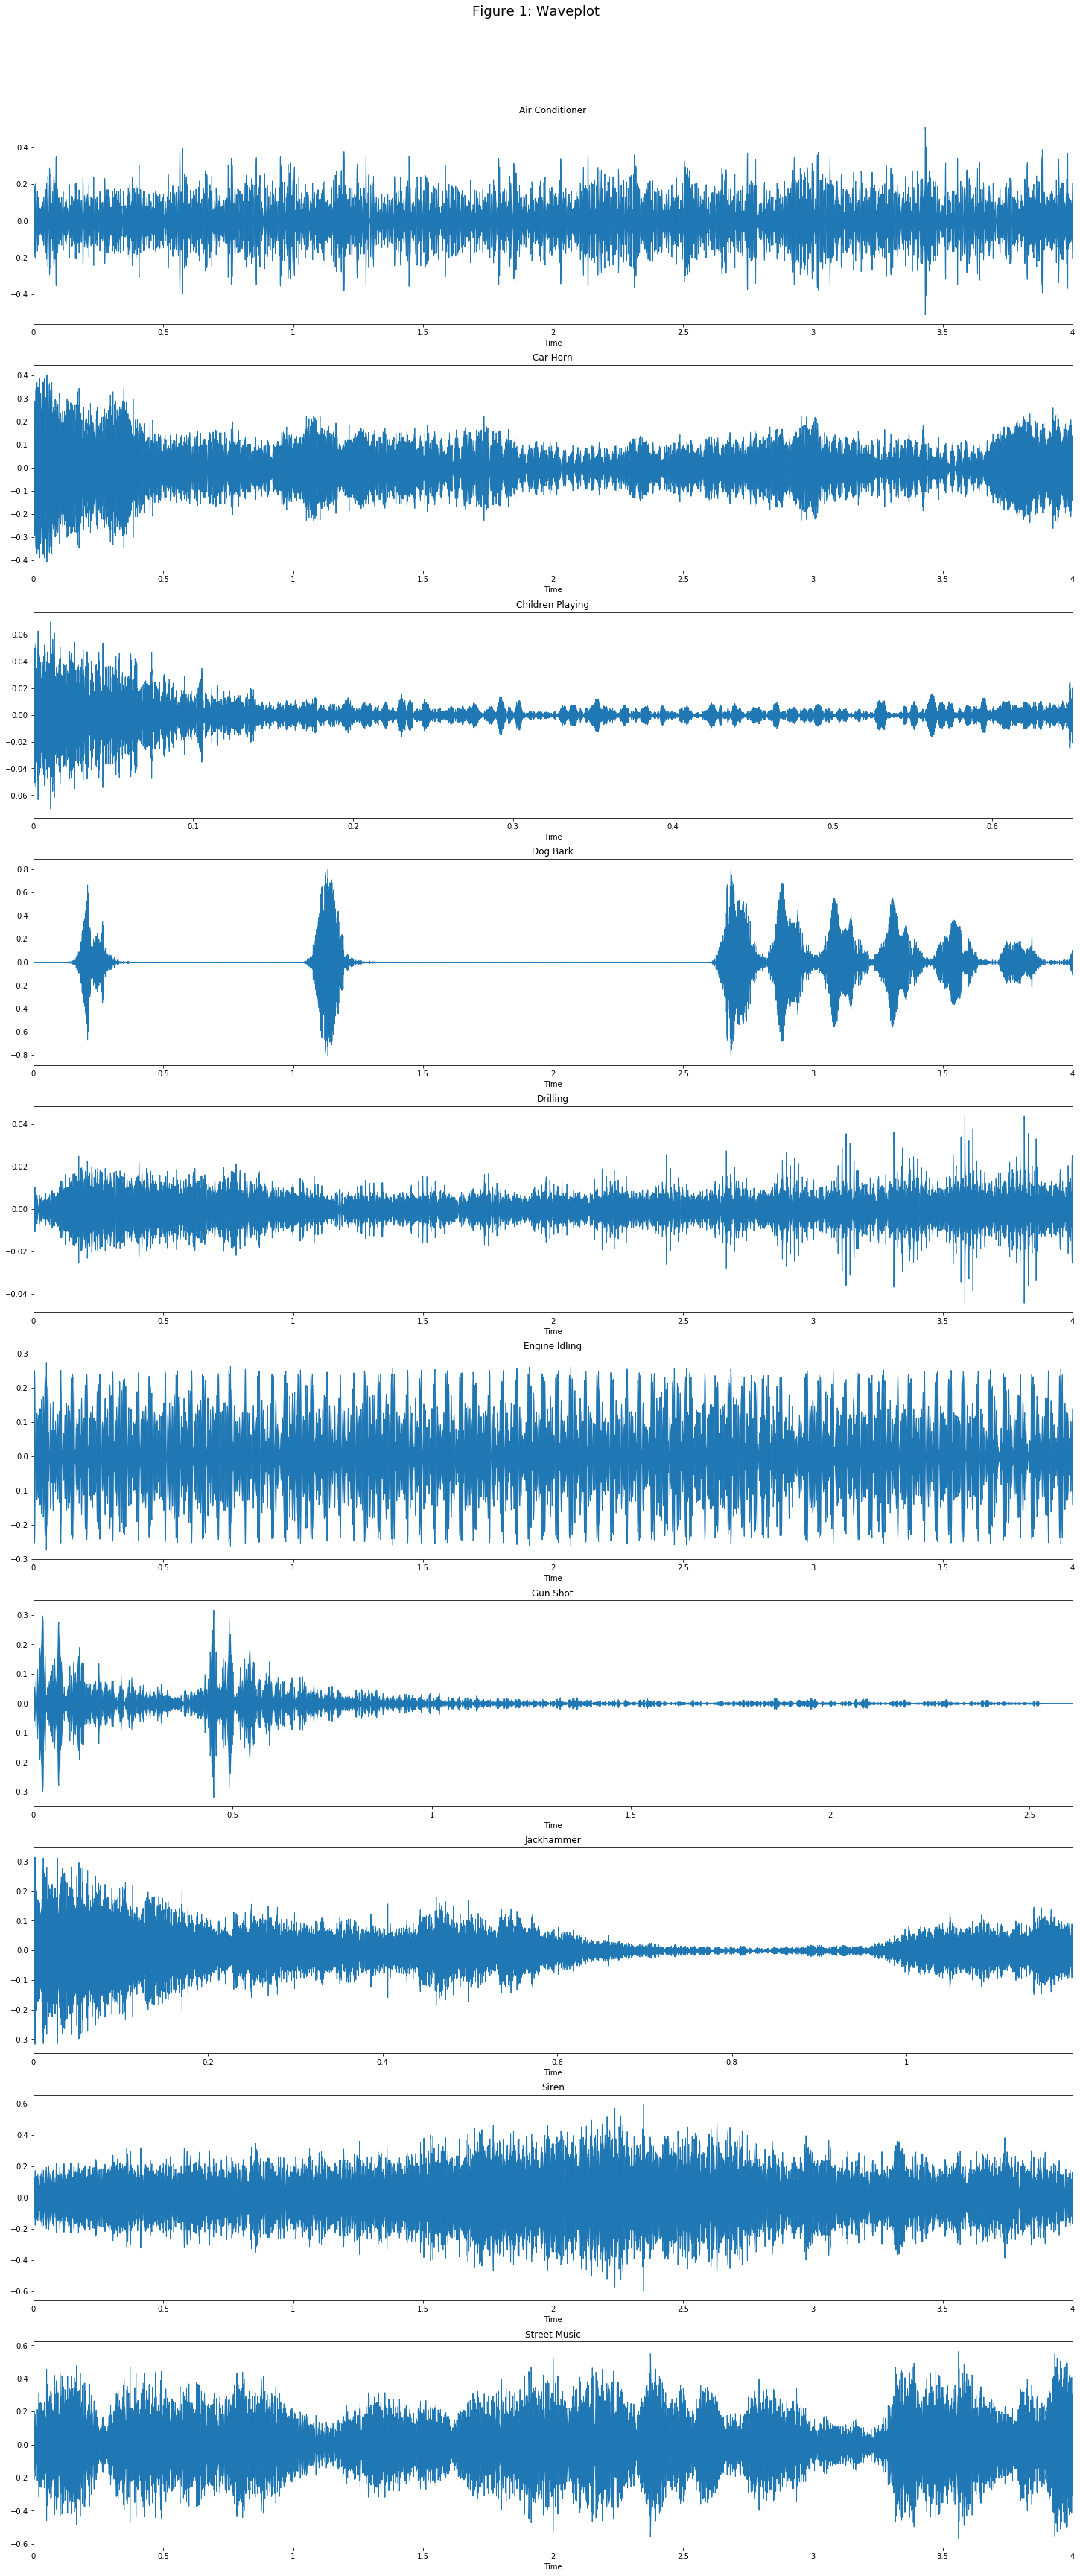

In [24]:
sound_file_paths = ["134717-0-0-0.wav","24074-1-0-3.wav","147764-4-2-0.wav","101415-3-0-2.wav",
"14113-4-0-0.wav","146186-5-0-10.wav","102305-6-0-0.wav",
"147764-4-7-0.wav","106905-8-0-0.wav","108041-9-0-2.wav"]

sound_names = ["air conditioner","car horn","children playing",
"dog bark","drilling","engine idling", "gun shot",
"jackhammer","siren","street music"]

raw_sounds = load_sound_files(sound_file_paths)

plot_waves(sound_names,raw_sounds)

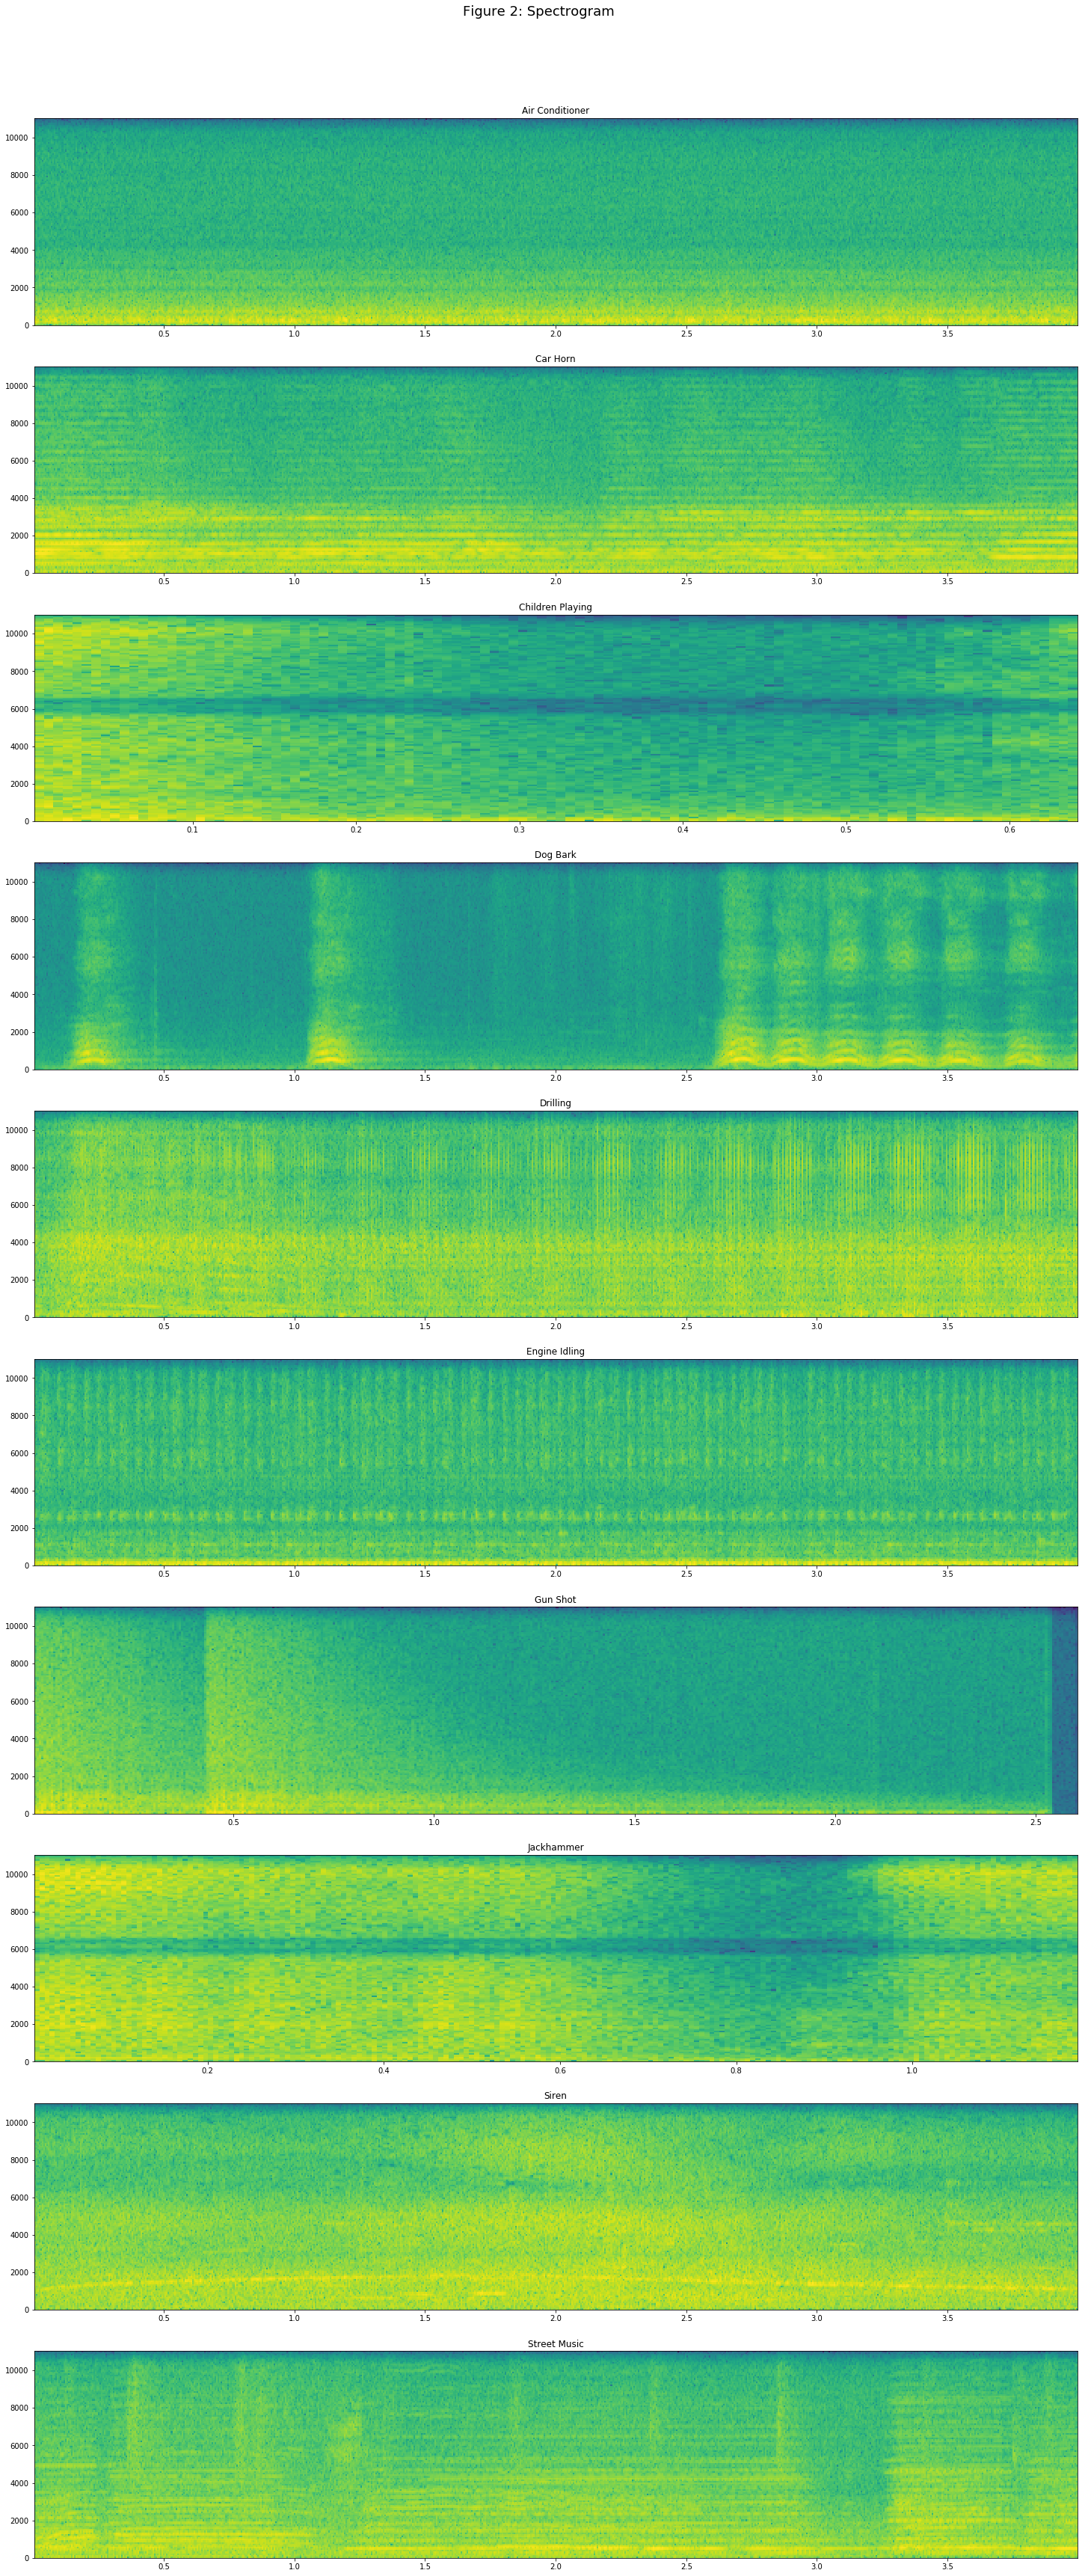

In [26]:
plot_specgram(sound_names,raw_sounds)

# Feature Extraction

In [164]:
import glob
import os
import librosa
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
import warnings
warnings.filterwarnings('ignore')

In [165]:
featureVectorLength = 140

In [166]:
def extract_features_from_file(file_name):
    raw_sound, sample_rate = librosa.load(file_name)
    mfccs = librosa.feature.mfcc(y=raw_sound, sr=sample_rate, n_mfcc = 20)

    mfccs_min = np.min(mfccs, axis=1)  
    mfccs_max = np.max(mfccs, axis=1)
    mfccs_median = np.median(mfccs, axis=1)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_variance = np.var(mfccs, axis=1)
    mfccs_skewness = skew(mfccs, axis=1)
    mfccs_kurtosis = kurtosis(mfccs, axis=1)

    return mfccs_min, mfccs_max, mfccs_median, mfccs_mean, mfccs_variance, mfccs_skewness, mfccs_kurtosis

In [133]:
def extract_features_from_directories(parent_dir, sub_dirs):
    file_ext = "*.wav"
    feature_matrix, labels = np.empty((0, featureVectorLength)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        for file_name in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)): 
            try:
                mfccs_min, mfccs_max, mfccs_median, mfccs_mean, mfccs_variance, mfccs_skeweness, mfccs_kurtosis = extract_features_from_file(file_name)
                print("Finished processing file: ", file_name)
            except Exception as e:
                print("Error encountered while processing file: ", file_name)
                continue

            # concatenate extracted features
            new_feature_vector = np.hstack([mfccs_min, mfccs_max, mfccs_median, mfccs_mean, mfccs_variance, mfccs_skeweness, mfccs_kurtosis])

            # add current feature vector as last row in feature matrix
            feature_matrix = np.vstack([feature_matrix, new_feature_vector])

            # extracts label from the file name. Change '\\' to  '/' on Unix systems
            labels = np.append(labels, file_name.split('/')[3].split('-')[1])

    return np.array(feature_matrix), np.array(labels, dtype=np.int)

In [174]:
def prepare_features(dirs):
    parent_dir = 'UrbanSound8K/audio'  # name of the directory which contains the recordings
    sub_dirs = dirs
    name = 'all_folds'

    # ndarrays
    features, labels = extract_features_from_directories(parent_dir, sub_dirs)

    # convert ndarray to pandas dataframe
    examples = pd.DataFrame(features, columns=list(range(1, featureVectorLength+1)))
    # convert ndarray to pandas series
    labels = pd.Series(labels.tolist())

    # store extracted data
    examples.to_pickle('Extracted_Features/' + name + '_features.pkl')
    labels.to_pickle('Extracted_Features/' + name + '_labels.pkl')

In [175]:
dirs = ["fold1", "fold2", "fold3", "fold4", "fold5", "fold6", "fold7", "fold8", "fold9", "fold10"]
prepare_features(dirs)

Finished processing file:  UrbanSound8K/audio/fold1/103074-7-1-1.wav
Finished processing file:  UrbanSound8K/audio/fold1/78360-4-0-20.wav
Finished processing file:  UrbanSound8K/audio/fold1/160009-2-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold1/103074-7-4-6.wav
Finished processing file:  UrbanSound8K/audio/fold1/143604-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/160009-2-0-22.wav
Finished processing file:  UrbanSound8K/audio/fold1/203440-3-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold1/159738-8-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold1/55020-4-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold1/180937-7-3-11.wav
Finished processing file:  UrbanSound8K/audio/fold1/57584-4-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold1/155202-9-0-38.wav
Finished processing file:  UrbanSound8K/audio/fold1/159738-8-0-19.wav
Finished processing file:  UrbanSound8K/audio/fold1/176714-2-0-55.wav
Finished processing file:  Urba

Finished processing file:  UrbanSound8K/audio/fold1/177621-0-0-88.wav
Finished processing file:  UrbanSound8K/audio/fold1/156194-1-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/40722-8-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold1/46669-4-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold1/57553-3-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/78360-4-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold1/176714-2-0-23.wav
Finished processing file:  UrbanSound8K/audio/fold1/191431-9-0-26.wav
Finished processing file:  UrbanSound8K/audio/fold1/137156-9-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold1/134717-0-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold1/101415-3-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold1/174294-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/176714-2-0-51.wav
Finished processing file:  UrbanSound8K/audio/fold1/194732-9-0-175.wav
Finished processing file:  Urban

Finished processing file:  UrbanSound8K/audio/fold1/193698-2-0-114.wav
Finished processing file:  UrbanSound8K/audio/fold1/57584-4-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold1/165645-4-5-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/157867-8-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold1/103074-7-3-3.wav
Finished processing file:  UrbanSound8K/audio/fold1/180937-7-4-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/46669-4-0-30.wav
Finished processing file:  UrbanSound8K/audio/fold1/157867-8-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold1/134717-0-0-28.wav
Finished processing file:  UrbanSound8K/audio/fold1/134717-0-0-23.wav
Finished processing file:  UrbanSound8K/audio/fold1/50901-0-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/177621-0-0-54.wav
Finished processing file:  UrbanSound8K/audio/fold1/196400-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/196079-2-0-0.wav
Finished processing file:  Urb

Finished processing file:  UrbanSound8K/audio/fold1/134717-0-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold1/165645-4-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/159738-8-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold1/108362-2-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold1/164312-3-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/103258-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/17913-4-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/180937-7-3-4.wav
Finished processing file:  UrbanSound8K/audio/fold1/143651-2-0-55.wav
Finished processing file:  UrbanSound8K/audio/fold1/197318-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/78360-4-0-22.wav
Finished processing file:  UrbanSound8K/audio/fold1/165645-4-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/134717-0-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold1/180937-7-3-18.wav
Finished processing file:  Urb

Finished processing file:  UrbanSound8K/audio/fold1/46669-4-0-39.wav
Finished processing file:  UrbanSound8K/audio/fold1/98223-7-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/180937-7-3-1.wav
Finished processing file:  UrbanSound8K/audio/fold1/177621-0-0-117.wav
Finished processing file:  UrbanSound8K/audio/fold1/191431-9-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold1/125791-3-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold1/176787-5-0-17.wav
Finished processing file:  UrbanSound8K/audio/fold1/146186-5-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold1/192124-2-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold1/108041-9-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold1/176787-5-0-18.wav
Finished processing file:  UrbanSound8K/audio/fold1/103074-7-4-5.wav
Finished processing file:  UrbanSound8K/audio/fold1/46656-6-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/193394-3-0-10.wav
Finished processing file:  Ur

Finished processing file:  UrbanSound8K/audio/fold1/17913-4-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/97317-2-0-22.wav
Finished processing file:  UrbanSound8K/audio/fold1/180937-7-4-7.wav
Finished processing file:  UrbanSound8K/audio/fold1/135776-2-0-49.wav
Finished processing file:  UrbanSound8K/audio/fold1/176787-5-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold1/46669-4-0-35.wav
Finished processing file:  UrbanSound8K/audio/fold1/103258-5-0-17.wav
Finished processing file:  UrbanSound8K/audio/fold1/176638-1-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/180937-7-3-27.wav
Finished processing file:  UrbanSound8K/audio/fold1/192124-2-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold1/86278-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/24074-1-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold1/71087-4-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/155310-3-0-0.wav
Finished processing file:  UrbanSo

Finished processing file:  UrbanSound8K/audio/fold1/57320-0-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold1/138031-2-0-22.wav
Finished processing file:  UrbanSound8K/audio/fold1/180937-7-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold1/46669-4-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold1/97317-2-0-23.wav
Finished processing file:  UrbanSound8K/audio/fold1/22962-4-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/159738-8-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold1/118101-3-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold1/15564-2-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold1/164312-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/134717-0-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold1/146186-5-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold1/150341-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/21684-9-0-7.wav
Finished processing file:  UrbanSou

Finished processing file:  UrbanSound8K/audio/fold1/17913-4-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold1/176787-5-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold1/147764-4-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/180256-3-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold1/40722-8-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold1/139951-9-0-33.wav
Finished processing file:  UrbanSound8K/audio/fold1/138031-2-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold1/103074-7-4-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/118279-8-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold1/139951-9-0-45.wav
Finished processing file:  UrbanSound8K/audio/fold1/46654-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold1/124489-9-0-18.wav
Finished processing file:  UrbanSound8K/audio/fold1/138031-2-0-28.wav
Finished processing file:  UrbanSound8K/audio/fold1/192124-2-0-3.wav
Finished processing file:  Urban

Finished processing file:  UrbanSound8K/audio/fold2/76086-4-0-29.wav
Finished processing file:  UrbanSound8K/audio/fold2/123688-8-0-18.wav
Finished processing file:  UrbanSound8K/audio/fold2/178520-2-0-42.wav
Finished processing file:  UrbanSound8K/audio/fold2/169098-7-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold2/182739-2-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold2/159750-8-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold2/204773-3-9-1.wav
Finished processing file:  UrbanSound8K/audio/fold2/155219-2-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold2/106015-5-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold2/102871-8-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold2/177592-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/106015-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/91396-8-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/174906-2-0-21.wav
Finished processing file:  Urba

Finished processing file:  UrbanSound8K/audio/fold2/147926-0-0-41.wav
Finished processing file:  UrbanSound8K/audio/fold2/152908-5-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold2/149370-9-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold2/196078-2-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/72539-3-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold2/147926-0-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold2/72567-1-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/159747-8-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold2/159747-8-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold2/60591-2-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold2/201652-5-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/96920-9-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/106015-5-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold2/203929-7-9-11.wav
Finished processing file:  Urban

Finished processing file:  UrbanSound8K/audio/fold2/189023-0-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold2/77751-4-9-2.wav
Finished processing file:  UrbanSound8K/audio/fold2/185800-4-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/178520-2-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold2/147926-0-0-42.wav
Finished processing file:  UrbanSound8K/audio/fold2/197320-6-10-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/76086-4-0-50.wav
Finished processing file:  UrbanSound8K/audio/fold2/22347-3-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/60591-2-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold2/180126-4-4-2.wav
Finished processing file:  UrbanSound8K/audio/fold2/34621-4-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/72567-1-4-2.wav
Finished processing file:  UrbanSound8K/audio/fold2/194841-9-0-144.wav
Finished processing file:  UrbanSound8K/audio/fold2/201652-5-0-3.wav
Finished processing file:  UrbanS

Finished processing file:  UrbanSound8K/audio/fold2/143970-5-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold2/169098-7-4-11.wav
Finished processing file:  UrbanSound8K/audio/fold2/178521-2-0-69.wav
Finished processing file:  UrbanSound8K/audio/fold2/33849-3-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/173995-3-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold2/40717-8-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/189991-0-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold2/46668-4-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold2/94710-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/93193-9-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold2/33849-3-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/102871-8-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold2/59594-4-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold2/33849-3-4-0.wav
Finished processing file:  UrbanSound8K

Finished processing file:  UrbanSound8K/audio/fold2/74507-0-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold2/146690-0-0-87.wav
Finished processing file:  UrbanSound8K/audio/fold2/98202-9-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold2/113201-5-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold2/147926-0-0-35.wav
Finished processing file:  UrbanSound8K/audio/fold2/156893-7-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/77751-4-9-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/72567-1-4-7.wav
Finished processing file:  UrbanSound8K/audio/fold2/169098-7-4-8.wav
Finished processing file:  UrbanSound8K/audio/fold2/102871-8-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold2/182739-2-0-56.wav
Finished processing file:  UrbanSound8K/audio/fold2/177592-5-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold2/34621-4-22-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/149254-9-0-30.wav
Finished processing file:  UrbanSo

Finished processing file:  UrbanSound8K/audio/fold2/74458-9-2-18.wav
Finished processing file:  UrbanSound8K/audio/fold2/123688-8-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold2/74495-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/59594-4-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold2/123688-8-2-3.wav
Finished processing file:  UrbanSound8K/audio/fold2/160011-2-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold2/96920-9-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold2/84359-2-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold2/159747-8-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold2/60591-2-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold2/159747-8-0-17.wav
Finished processing file:  UrbanSound8K/audio/fold2/77751-4-8-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/123688-8-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold2/178520-2-0-23.wav
Finished processing file:  UrbanSou

Finished processing file:  UrbanSound8K/audio/fold2/169098-7-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold2/74226-9-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold2/106015-5-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold2/23131-3-4-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/147926-0-0-39.wav
Finished processing file:  UrbanSound8K/audio/fold2/146690-0-0-125.wav
Finished processing file:  UrbanSound8K/audio/fold2/197320-6-12-0.wav
Finished processing file:  UrbanSound8K/audio/fold2/172593-2-0-28.wav
Finished processing file:  UrbanSound8K/audio/fold2/203929-7-2-9.wav
Finished processing file:  UrbanSound8K/audio/fold2/194841-9-0-164.wav
Finished processing file:  UrbanSound8K/audio/fold2/14780-9-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold2/146690-0-0-93.wav
Finished processing file:  UrbanSound8K/audio/fold2/168713-9-0-62.wav
Finished processing file:  UrbanSound8K/audio/fold2/201652-5-2-4.wav
Finished processing file:  

Finished processing file:  UrbanSound8K/audio/fold3/62837-7-1-62.wav
Finished processing file:  UrbanSound8K/audio/fold3/12647-3-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/93065-9-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold3/22601-8-0-21.wav
Finished processing file:  UrbanSound8K/audio/fold3/98681-9-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold3/17853-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/195451-5-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold3/185375-9-0-33.wav
Finished processing file:  UrbanSound8K/audio/fold3/76221-2-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/165039-7-14-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/177742-0-0-111.wav
Finished processing file:  UrbanSound8K/audio/fold3/144068-5-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold3/62837-7-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold3/195451-5-0-19.wav
Finished processing file:  UrbanSo

Finished processing file:  UrbanSound8K/audio/fold3/103199-4-2-4.wav
Finished processing file:  UrbanSound8K/audio/fold3/22601-8-0-46.wav
Finished processing file:  UrbanSound8K/audio/fold3/155263-2-0-22.wav
Finished processing file:  UrbanSound8K/audio/fold3/182103-9-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/30204-0-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold3/184623-8-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/135526-6-4-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/69598-4-6-1.wav
Finished processing file:  UrbanSound8K/audio/fold3/195451-5-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold3/58857-2-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold3/90846-8-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/184725-3-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold3/58857-2-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold3/94636-8-0-3.wav
Finished processing file:  UrbanSound

Finished processing file:  UrbanSound8K/audio/fold3/42097-7-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold3/76221-2-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold3/32318-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/63095-4-1-23.wav
Finished processing file:  UrbanSound8K/audio/fold3/17853-5-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold3/186334-2-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold3/177742-0-0-203.wav
Finished processing file:  UrbanSound8K/audio/fold3/22601-8-0-39.wav
Finished processing file:  UrbanSound8K/audio/fold3/62837-7-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold3/176631-1-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/125523-3-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold3/49485-9-0-91.wav
Finished processing file:  UrbanSound8K/audio/fold3/103199-4-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold3/37560-4-0-0.wav
Finished processing file:  UrbanSound

Finished processing file:  UrbanSound8K/audio/fold3/165039-7-13-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/49769-5-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/166101-5-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold3/17853-5-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold3/165039-7-8-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/151149-2-0-22.wav
Finished processing file:  UrbanSound8K/audio/fold3/19338-5-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/62837-7-1-53.wav
Finished processing file:  UrbanSound8K/audio/fold3/93065-9-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold3/90014-8-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold3/186339-9-0-17.wav
Finished processing file:  UrbanSound8K/audio/fold3/37560-4-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold3/42117-8-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold3/52077-3-0-8.wav
Finished processing file:  UrbanSound8K

Finished processing file:  UrbanSound8K/audio/fold3/62837-7-1-27.wav
Finished processing file:  UrbanSound8K/audio/fold3/77769-9-0-17.wav
Finished processing file:  UrbanSound8K/audio/fold3/54067-2-0-80.wav
Finished processing file:  UrbanSound8K/audio/fold3/62837-7-1-2.wav
Finished processing file:  UrbanSound8K/audio/fold3/22601-8-0-41.wav
Finished processing file:  UrbanSound8K/audio/fold3/186339-9-0-18.wav
Finished processing file:  UrbanSound8K/audio/fold3/186336-9-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/94636-8-0-18.wav
Finished processing file:  UrbanSound8K/audio/fold3/62837-7-1-4.wav
Finished processing file:  UrbanSound8K/audio/fold3/37560-4-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold3/197074-3-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold3/22601-8-0-49.wav
Finished processing file:  UrbanSound8K/audio/fold3/166101-5-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/61791-9-1-42.wav
Finished processing file:  UrbanSoun

Finished processing file:  UrbanSound8K/audio/fold3/90014-8-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold3/62837-7-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold3/22601-8-0-44.wav
Finished processing file:  UrbanSound8K/audio/fold3/19496-3-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/165039-7-6-1.wav
Finished processing file:  UrbanSound8K/audio/fold3/31884-7-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/44831-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/185373-9-1-46.wav
Finished processing file:  UrbanSound8K/audio/fold3/135526-6-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/22601-8-0-33.wav
Finished processing file:  UrbanSound8K/audio/fold3/29721-4-0-10.wav
Finished processing file:  UrbanSound8K/audio/fold3/159761-0-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold3/132855-2-0-99.wav
Finished processing file:  UrbanSound8K/audio/fold3/135526-6-1-0.wav
Finished processing file:  UrbanSound

Finished processing file:  UrbanSound8K/audio/fold3/37560-4-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold3/90014-8-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold3/22601-8-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold3/78326-9-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/49485-9-0-138.wav
Finished processing file:  UrbanSound8K/audio/fold3/125523-3-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold3/102105-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/42117-8-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold3/146714-0-0-35.wav
Finished processing file:  UrbanSound8K/audio/fold3/22601-8-0-34.wav
Finished processing file:  UrbanSound8K/audio/fold3/144068-5-4-4.wav
Finished processing file:  UrbanSound8K/audio/fold3/33696-3-4-1.wav
Finished processing file:  UrbanSound8K/audio/fold3/49485-9-0-28.wav
Finished processing file:  UrbanSound8K/audio/fold3/29721-4-0-6.wav
Finished processing file:  UrbanSound8

Finished processing file:  UrbanSound8K/audio/fold3/146714-0-0-45.wav
Finished processing file:  UrbanSound8K/audio/fold3/103199-4-2-1.wav
Finished processing file:  UrbanSound8K/audio/fold3/42117-8-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/13230-0-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold3/199769-1-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold3/135526-6-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold3/29721-4-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold3/132855-2-0-41.wav
Finished processing file:  UrbanSound8K/audio/fold3/177742-0-0-102.wav
Finished processing file:  UrbanSound8K/audio/fold3/169044-2-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold3/151149-2-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold3/22601-8-0-22.wav
Finished processing file:  UrbanSound8K/audio/fold3/22601-8-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold3/94636-8-0-17.wav
Finished processing file:  Urban

Finished processing file:  UrbanSound8K/audio/fold4/146709-0-0-65.wav
Finished processing file:  UrbanSound8K/audio/fold4/158608-8-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/47019-2-0-44.wav
Finished processing file:  UrbanSound8K/audio/fold4/169466-4-2-4.wav
Finished processing file:  UrbanSound8K/audio/fold4/151877-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/159751-8-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold4/159752-8-2-3.wav
Finished processing file:  UrbanSound8K/audio/fold4/162435-6-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/55018-0-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold4/180977-3-1-1.wav
Finished processing file:  UrbanSound8K/audio/fold4/81068-5-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/29722-4-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold4/7389-1-4-9.wav
Finished processing file:  UrbanSound8K/audio/fold4/24347-8-0-86.wav
Finished processing file:  UrbanSound8

Finished processing file:  UrbanSound8K/audio/fold4/17480-2-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold4/171305-7-20-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/154758-5-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold4/135528-6-7-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/24347-8-0-27.wav
Finished processing file:  UrbanSound8K/audio/fold4/132016-7-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold4/135528-6-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/55018-0-0-248.wav
Finished processing file:  UrbanSound8K/audio/fold4/84317-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/159752-8-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold4/171305-7-9-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/148463-7-2-2.wav
Finished processing file:  UrbanSound8K/audio/fold4/16692-5-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold4/170564-2-1-9.wav
Finished processing file:  UrbanSo

Finished processing file:  UrbanSound8K/audio/fold4/34056-2-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold4/166942-0-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold4/157799-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/146709-0-0-63.wav
Finished processing file:  UrbanSound8K/audio/fold4/144007-5-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold4/14110-4-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold4/29722-4-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/151005-4-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold4/172338-9-0-20.wav
Finished processing file:  UrbanSound8K/audio/fold4/171305-7-28-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/158608-8-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold4/55018-0-0-87.wav
Finished processing file:  UrbanSound8K/audio/fold4/22883-7-21-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/76585-9-0-57.wav
Finished processing file:  UrbanS

Finished processing file:  UrbanSound8K/audio/fold4/176638-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/109711-3-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/140824-4-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/159751-8-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold4/159751-8-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold4/47019-2-0-65.wav
Finished processing file:  UrbanSound8K/audio/fold4/171305-7-8-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/195969-0-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold4/169466-4-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold4/146709-0-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold4/159752-8-2-2.wav
Finished processing file:  UrbanSound8K/audio/fold4/202517-0-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/22883-7-17-2.wav
Finished processing file:  UrbanSound8K/audio/fold4/206037-2-0-38.wav
Finished processing file:  Urba

Finished processing file:  UrbanSound8K/audio/fold4/61626-9-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold4/24347-8-0-48.wav
Finished processing file:  UrbanSound8K/audio/fold4/128160-5-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold4/54173-2-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold4/135528-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/22883-7-44-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/158608-8-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold4/63932-3-1-1.wav
Finished processing file:  UrbanSound8K/audio/fold4/62461-0-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/146709-0-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold4/144007-5-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold4/171305-7-18-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/128607-4-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/128160-5-0-6.wav
Finished processing file:  UrbanSou

Finished processing file:  UrbanSound8K/audio/fold4/166942-0-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold4/47926-3-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/192382-2-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold4/209864-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/171305-7-6-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/195969-0-0-26.wav
Finished processing file:  UrbanSound8K/audio/fold4/7064-6-4-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/170564-2-1-32.wav
Finished processing file:  UrbanSound8K/audio/fold4/195969-0-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold4/144351-4-3-3.wav
Finished processing file:  UrbanSound8K/audio/fold4/24347-8-0-98.wav
Finished processing file:  UrbanSound8K/audio/fold4/47926-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/22883-7-99-3.wav
Finished processing file:  UrbanSound8K/audio/fold4/165785-4-2-0.wav
Finished processing file:  UrbanSo

Finished processing file:  UrbanSound8K/audio/fold4/159753-8-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold4/144007-5-1-10.wav
Finished processing file:  UrbanSound8K/audio/fold4/135528-6-4-1.wav
Finished processing file:  UrbanSound8K/audio/fold4/22883-7-58-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/35629-3-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/148463-7-3-7.wav
Finished processing file:  UrbanSound8K/audio/fold4/159752-8-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold4/35549-9-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold4/39968-9-0-181.wav
Finished processing file:  UrbanSound8K/audio/fold4/85544-3-5-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/195969-0-0-10.wav
Finished processing file:  UrbanSound8K/audio/fold4/20688-2-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold4/99157-9-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold4/61626-9-0-2.wav
Finished processing file:  UrbanSo

Finished processing file:  UrbanSound8K/audio/fold4/135528-6-8-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/109711-3-2-6.wav
Finished processing file:  UrbanSound8K/audio/fold4/99157-9-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold4/22883-7-67-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/169466-4-3-3.wav
Finished processing file:  UrbanSound8K/audio/fold4/24347-8-0-92.wav
Finished processing file:  UrbanSound8K/audio/fold4/24347-8-0-65.wav
Finished processing file:  UrbanSound8K/audio/fold4/61790-9-0-10.wav
Finished processing file:  UrbanSound8K/audio/fold4/24347-8-0-58.wav
Finished processing file:  UrbanSound8K/audio/fold4/24347-8-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold4/7389-1-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold4/196072-2-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold4/16692-5-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold4/22883-7-51-0.wav
Finished processing file:  UrbanSound8

Finished processing file:  UrbanSound8K/audio/fold5/115239-9-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold5/159701-6-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/72259-1-9-16.wav
Finished processing file:  UrbanSound8K/audio/fold5/164782-8-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/72259-1-7-17.wav
Finished processing file:  UrbanSound8K/audio/fold5/178497-3-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold5/178686-0-0-31.wav
Finished processing file:  UrbanSound8K/audio/fold5/164344-9-0-38.wav
Finished processing file:  UrbanSound8K/audio/fold5/104998-7-8-15.wav
Finished processing file:  UrbanSound8K/audio/fold5/178099-9-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold5/159701-6-6-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/72259-1-7-1.wav
Finished processing file:  UrbanSound8K/audio/fold5/100852-0-0-19.wav
Finished processing file:  UrbanSound8K/audio/fold5/165774-7-0-0.wav
Finished processing file:  Urb

Finished processing file:  UrbanSound8K/audio/fold5/156869-8-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold5/121286-0-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold5/178686-0-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold5/121286-0-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold5/66587-3-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/178686-0-0-66.wav
Finished processing file:  UrbanSound8K/audio/fold5/71171-4-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/178260-7-3-5.wav
Finished processing file:  UrbanSound8K/audio/fold5/145611-6-4-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/203654-9-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold5/178686-0-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold5/111671-8-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold5/34872-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/17578-5-0-27.wav
Finished processing file:  UrbanSou

Finished processing file:  UrbanSound8K/audio/fold5/72259-1-7-3.wav
Finished processing file:  UrbanSound8K/audio/fold5/100852-0-0-30.wav
Finished processing file:  UrbanSound8K/audio/fold5/178260-7-3-3.wav
Finished processing file:  UrbanSound8K/audio/fold5/72259-1-7-8.wav
Finished processing file:  UrbanSound8K/audio/fold5/180128-4-17-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/100852-0-0-23.wav
Finished processing file:  UrbanSound8K/audio/fold5/111671-8-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold5/104998-7-16-6.wav
Finished processing file:  UrbanSound8K/audio/fold5/164667-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/178825-2-0-70.wav
Finished processing file:  UrbanSound8K/audio/fold5/121286-0-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold5/121286-0-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold5/6508-9-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold5/72259-1-9-2.wav
Finished processing file:  Urban

Finished processing file:  UrbanSound8K/audio/fold5/106487-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/205874-4-10-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/72259-1-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold5/26177-1-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/139948-3-4-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/203913-8-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/13577-3-5-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/31150-2-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold5/190893-2-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold5/178099-9-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold5/85569-0-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold5/65381-3-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold5/71173-2-0-103.wav
Finished processing file:  UrbanSound8K/audio/fold5/178260-7-5-0.wav
Finished processing file:  UrbanSound

Finished processing file:  UrbanSound8K/audio/fold5/71171-4-1-3.wav
Finished processing file:  UrbanSound8K/audio/fold5/43787-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/159701-6-5-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/111671-8-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold5/23219-5-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold5/108357-9-0-30.wav
Finished processing file:  UrbanSound8K/audio/fold5/108357-9-0-27.wav
Finished processing file:  UrbanSound8K/audio/fold5/191382-3-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold5/60846-0-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/72259-1-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/165774-7-6-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/172460-9-0-94.wav
Finished processing file:  UrbanSound8K/audio/fold5/20015-3-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold5/71173-2-0-69.wav
Finished processing file:  UrbanSoun

Finished processing file:  UrbanSound8K/audio/fold5/190893-2-0-28.wav
Finished processing file:  UrbanSound8K/audio/fold5/85569-0-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold5/31150-2-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold5/71171-4-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold5/23219-5-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold5/159754-8-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/85569-0-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold5/105425-9-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold5/164344-9-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/26184-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/178260-7-7-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/178260-7-1-8.wav
Finished processing file:  UrbanSound8K/audio/fold5/72259-1-9-5.wav
Finished processing file:  UrbanSound8K/audio/fold5/104998-7-16-5.wav
Finished processing file:  UrbanSound8

Finished processing file:  UrbanSound8K/audio/fold5/162432-6-12-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/71171-4-1-5.wav
Finished processing file:  UrbanSound8K/audio/fold5/180125-4-3-22.wav
Finished processing file:  UrbanSound8K/audio/fold5/197243-3-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/164782-8-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold5/172460-9-0-101.wav
Finished processing file:  UrbanSound8K/audio/fold5/86284-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/29937-3-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold5/50413-4-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/160010-2-0-37.wav
Finished processing file:  UrbanSound8K/audio/fold5/49312-2-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold5/7066-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/104998-7-10-8.wav
Finished processing file:  UrbanSound8K/audio/fold5/85569-0-0-2.wav
Finished processing file:  UrbanSoun

Finished processing file:  UrbanSound8K/audio/fold5/178260-7-1-1.wav
Finished processing file:  UrbanSound8K/audio/fold5/104998-7-15-3.wav
Finished processing file:  UrbanSound8K/audio/fold5/203654-9-0-42.wav
Finished processing file:  UrbanSound8K/audio/fold5/106487-5-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold5/121286-0-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/203654-9-0-60.wav
Finished processing file:  UrbanSound8K/audio/fold5/21187-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/118440-4-7-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/110371-3-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/139665-9-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold5/131199-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold5/6508-9-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold5/156869-8-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold5/83196-9-0-3.wav
Finished processing file:  UrbanSou

Finished processing file:  UrbanSound8K/audio/fold6/94632-5-0-29.wav
Finished processing file:  UrbanSound8K/audio/fold6/39854-5-1-4.wav
Finished processing file:  UrbanSound8K/audio/fold6/74726-8-2-3.wav
Finished processing file:  UrbanSound8K/audio/fold6/30206-7-0-26.wav
Finished processing file:  UrbanSound8K/audio/fold6/204240-0-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold6/34952-8-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold6/94632-5-1-23.wav
Finished processing file:  UrbanSound8K/audio/fold6/69962-2-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold6/122738-9-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold6/148835-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/135544-6-17-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/121285-0-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold6/148833-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/107842-4-2-4.wav
Finished processing file:  UrbanSo

Finished processing file:  UrbanSound8K/audio/fold6/131918-7-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold6/167701-4-4-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/24364-4-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold6/135544-6-12-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/169045-2-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold6/204240-0-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold6/97392-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/58005-4-0-26.wav
Finished processing file:  UrbanSound8K/audio/fold6/121285-0-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold6/46299-2-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold6/35548-9-0-23.wav
Finished processing file:  UrbanSound8K/audio/fold6/68657-1-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/89442-9-0-17.wav
Finished processing file:  UrbanSound8K/audio/fold6/24364-4-0-9.wav
Finished processing file:  UrbanSound

Finished processing file:  UrbanSound8K/audio/fold6/66000-9-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/110868-9-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold6/52882-2-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold6/132021-7-0-10.wav
Finished processing file:  UrbanSound8K/audio/fold6/115243-9-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold6/34643-4-2-2.wav
Finished processing file:  UrbanSound8K/audio/fold6/63724-0-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold6/74726-8-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold6/94632-5-0-33.wav
Finished processing file:  UrbanSound8K/audio/fold6/107842-4-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/111386-5-1-4.wav
Finished processing file:  UrbanSound8K/audio/fold6/175917-3-1-1.wav
Finished processing file:  UrbanSound8K/audio/fold6/30206-7-0-18.wav
Finished processing file:  UrbanSound8K/audio/fold6/99710-9-0-5.wav
Finished processing file:  UrbanSou

Finished processing file:  UrbanSound8K/audio/fold6/159702-6-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/167701-4-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/166931-4-4-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/83680-5-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold6/204240-0-0-18.wav
Finished processing file:  UrbanSound8K/audio/fold6/133797-6-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/74726-8-1-2.wav
Finished processing file:  UrbanSound8K/audio/fold6/94632-5-0-10.wav
Finished processing file:  UrbanSound8K/audio/fold6/78651-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/184805-0-0-47.wav
Finished processing file:  UrbanSound8K/audio/fold6/159702-6-5-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/74726-8-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold6/30206-7-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold6/111386-5-1-6.wav
Finished processing file:  UrbanSoun

Finished processing file:  UrbanSound8K/audio/fold6/194321-9-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold6/204240-0-0-29.wav
Finished processing file:  UrbanSound8K/audio/fold6/204240-0-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold6/110868-9-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold6/30206-7-0-25.wav
Finished processing file:  UrbanSound8K/audio/fold6/98263-9-0-22.wav
Finished processing file:  UrbanSound8K/audio/fold6/110868-9-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold6/155317-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/132021-7-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold6/184805-0-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold6/204240-0-0-31.wav
Finished processing file:  UrbanSound8K/audio/fold6/63724-0-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold6/34952-8-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold6/14114-4-0-0.wav
Finished processing file:  UrbanS

Finished processing file:  UrbanSound8K/audio/fold6/184805-0-0-88.wav
Finished processing file:  UrbanSound8K/audio/fold6/148834-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/30206-7-0-20.wav
Finished processing file:  UrbanSound8K/audio/fold6/30206-7-0-27.wav
Finished processing file:  UrbanSound8K/audio/fold6/129356-2-0-118.wav
Finished processing file:  UrbanSound8K/audio/fold6/14358-3-0-85.wav
Finished processing file:  UrbanSound8K/audio/fold6/155127-9-1-2.wav
Finished processing file:  UrbanSound8K/audio/fold6/204240-0-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold6/31973-9-0-64.wav
Finished processing file:  UrbanSound8K/audio/fold6/108638-9-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold6/204240-0-0-23.wav
Finished processing file:  UrbanSound8K/audio/fold6/196088-2-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/54697-7-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold6/159702-6-3-0.wav
Finished processing file:  Urba

Finished processing file:  UrbanSound8K/audio/fold6/97331-2-0-98.wav
Finished processing file:  UrbanSound8K/audio/fold6/204240-0-0-27.wav
Finished processing file:  UrbanSound8K/audio/fold6/204240-0-0-19.wav
Finished processing file:  UrbanSound8K/audio/fold6/128891-3-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold6/162702-1-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/111386-5-1-10.wav
Finished processing file:  UrbanSound8K/audio/fold6/75490-8-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/131918-7-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold6/39884-5-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold6/133797-6-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold6/166931-4-2-13.wav
Finished processing file:  UrbanSound8K/audio/fold6/104327-2-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold6/24364-4-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold6/184805-0-0-121.wav
Finished processing file:  Urba

Finished processing file:  UrbanSound8K/audio/fold7/44737-5-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold7/209992-5-2-116.wav
Finished processing file:  UrbanSound8K/audio/fold7/43805-8-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/105289-8-1-2.wav
Finished processing file:  UrbanSound8K/audio/fold7/50629-4-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/146845-0-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold7/107357-8-1-16.wav
Finished processing file:  UrbanSound8K/audio/fold7/177729-0-0-120.wav
Finished processing file:  UrbanSound8K/audio/fold7/135527-6-10-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/104625-4-0-53.wav
Finished processing file:  UrbanSound8K/audio/fold7/99812-1-5-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/177537-7-0-23.wav
Finished processing file:  UrbanSound8K/audio/fold7/50629-4-1-11.wav
Finished processing file:  UrbanSound8K/audio/fold7/66619-2-0-5.wav
Finished processing file:  Urba

Finished processing file:  UrbanSound8K/audio/fold7/189981-0-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold7/36264-9-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold7/196070-2-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold7/36264-9-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/175296-2-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold7/171165-9-0-54.wav
Finished processing file:  UrbanSound8K/audio/fold7/155314-3-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold7/202516-0-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold7/105289-8-2-7.wav
Finished processing file:  UrbanSound8K/audio/fold7/209992-5-3-6.wav
Finished processing file:  UrbanSound8K/audio/fold7/74850-9-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold7/201988-5-0-17.wav
Finished processing file:  UrbanSound8K/audio/fold7/518-4-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold7/180257-3-0-1.wav
Finished processing file:  UrbanSoun

Finished processing file:  UrbanSound8K/audio/fold7/85362-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/202516-0-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold7/177537-7-0-20.wav
Finished processing file:  UrbanSound8K/audio/fold7/102853-8-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold7/57323-8-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold7/177537-7-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/202516-0-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold7/49313-2-0-30.wav
Finished processing file:  UrbanSound8K/audio/fold7/192236-3-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold7/177537-7-0-22.wav
Finished processing file:  UrbanSound8K/audio/fold7/107357-8-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold7/14772-7-7-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/14772-7-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/28385-9-0-32.wav
Finished processing file:  UrbanSoun

Finished processing file:  UrbanSound8K/audio/fold7/104625-4-0-27.wav
Finished processing file:  UrbanSound8K/audio/fold7/173891-9-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold7/57323-8-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold7/209992-5-3-5.wav
Finished processing file:  UrbanSound8K/audio/fold7/146845-0-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold7/173891-9-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold7/518-4-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold7/107357-8-1-7.wav
Finished processing file:  UrbanSound8K/audio/fold7/102853-8-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold7/61503-2-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold7/74965-4-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/21683-9-0-34.wav
Finished processing file:  UrbanSound8K/audio/fold7/74965-4-1-2.wav
Finished processing file:  UrbanSound8K/audio/fold7/50415-4-0-1.wav
Finished processing file:  UrbanSound8K

Finished processing file:  UrbanSound8K/audio/fold7/135527-6-14-7.wav
Finished processing file:  UrbanSound8K/audio/fold7/177537-7-0-18.wav
Finished processing file:  UrbanSound8K/audio/fold7/105289-8-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/27217-3-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold7/173891-9-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold7/201988-5-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold7/135527-6-4-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/39857-5-5-1.wav
Finished processing file:  UrbanSound8K/audio/fold7/71529-4-1-4.wav
Finished processing file:  UrbanSound8K/audio/fold7/34871-3-6-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/127443-4-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/177729-0-0-97.wav
Finished processing file:  UrbanSound8K/audio/fold7/207962-3-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/107357-8-1-0.wav
Finished processing file:  UrbanSo

Finished processing file:  UrbanSound8K/audio/fold7/177537-7-2-1.wav
Finished processing file:  UrbanSound8K/audio/fold7/97606-7-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/149193-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/50629-4-4-3.wav
Finished processing file:  UrbanSound8K/audio/fold7/207216-2-0-66.wav
Finished processing file:  UrbanSound8K/audio/fold7/57323-8-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold7/89443-9-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold7/61503-2-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold7/165644-4-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold7/177537-7-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold7/61789-9-0-10.wav
Finished processing file:  UrbanSound8K/audio/fold7/36264-9-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold7/105289-8-2-4.wav
Finished processing file:  UrbanSound8K/audio/fold7/50614-3-0-0.wav
Finished processing file:  UrbanSound8K/

Finished processing file:  UrbanSound8K/audio/fold7/65745-3-0-21.wav
Finished processing file:  UrbanSound8K/audio/fold7/107357-8-1-2.wav
Finished processing file:  UrbanSound8K/audio/fold7/105289-8-2-3.wav
Finished processing file:  UrbanSound8K/audio/fold7/57323-8-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/101848-9-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold7/89209-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/201988-5-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold7/67049-3-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold7/74965-4-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold7/50629-4-1-4.wav
Finished processing file:  UrbanSound8K/audio/fold7/99812-1-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold7/89099-4-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold7/135527-6-8-0.wav
Finished processing file:  UrbanSound8K/audio/fold7/191687-3-0-11.wav
Finished processing file:  UrbanSound8K

Finished processing file:  UrbanSound8K/audio/fold8/169043-2-0-21.wav
Finished processing file:  UrbanSound8K/audio/fold8/156358-5-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold8/39967-9-0-44.wav
Finished processing file:  UrbanSound8K/audio/fold8/125678-7-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold8/54914-2-0-27.wav
Finished processing file:  UrbanSound8K/audio/fold8/179039-9-0-40.wav
Finished processing file:  UrbanSound8K/audio/fold8/180132-4-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/168037-4-6-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/113202-5-0-21.wav
Finished processing file:  UrbanSound8K/audio/fold8/16860-9-0-28.wav
Finished processing file:  UrbanSound8K/audio/fold8/113202-5-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold8/74677-0-0-67.wav
Finished processing file:  UrbanSound8K/audio/fold8/54914-2-0-34.wav
Finished processing file:  UrbanSound8K/audio/fold8/125678-7-0-5.wav
Finished processing file:  Urba

Finished processing file:  UrbanSound8K/audio/fold8/161129-4-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold8/161129-4-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold8/125520-1-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/189825-9-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold8/126153-9-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold8/169043-2-0-10.wav
Finished processing file:  UrbanSound8K/audio/fold8/31325-3-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/71177-8-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/205610-4-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold8/125678-7-2-1.wav
Finished processing file:  UrbanSound8K/audio/fold8/76085-4-0-35.wav
Finished processing file:  UrbanSound8K/audio/fold8/174285-6-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/99179-9-0-58.wav
Finished processing file:  UrbanSound8K/audio/fold8/133473-8-0-3.wav
Finished processing file:  UrbanSo

Finished processing file:  UrbanSound8K/audio/fold8/160016-2-0-37.wav
Finished processing file:  UrbanSound8K/audio/fold8/44110-3-4-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/161129-4-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold8/50668-5-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/113202-5-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold8/66324-9-0-19.wav
Finished processing file:  UrbanSound8K/audio/fold8/177726-0-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold8/157868-8-0-25.wav
Finished processing file:  UrbanSound8K/audio/fold8/76266-2-0-80.wav
Finished processing file:  UrbanSound8K/audio/fold8/148632-8-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold8/162433-6-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/76085-4-0-62.wav
Finished processing file:  UrbanSound8K/audio/fold8/155283-1-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/103076-3-1-0.wav
Finished processing file:  Urba

Finished processing file:  UrbanSound8K/audio/fold8/91209-5-1-4.wav
Finished processing file:  UrbanSound8K/audio/fold8/194733-9-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold8/50613-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/125678-7-4-8.wav
Finished processing file:  UrbanSound8K/audio/fold8/168037-4-12-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/205610-4-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold8/157649-3-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold8/96657-8-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold8/113202-5-0-26.wav
Finished processing file:  UrbanSound8K/audio/fold8/106905-5-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold8/168037-4-10-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/180134-4-2-9.wav
Finished processing file:  UrbanSound8K/audio/fold8/133090-2-0-37.wav
Finished processing file:  UrbanSound8K/audio/fold8/117181-8-0-2.wav
Finished processing file:  Urban

Finished processing file:  UrbanSound8K/audio/fold8/54914-2-0-48.wav
Finished processing file:  UrbanSound8K/audio/fold8/162103-0-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold8/162103-0-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold8/81787-2-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold8/148632-8-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold8/113202-5-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold8/113202-5-0-22.wav
Finished processing file:  UrbanSound8K/audio/fold8/180134-4-2-15.wav
Finished processing file:  UrbanSound8K/audio/fold8/125678-7-2-8.wav
Finished processing file:  UrbanSound8K/audio/fold8/76266-2-0-91.wav
Finished processing file:  UrbanSound8K/audio/fold8/157868-8-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold8/207214-2-0-26.wav
Finished processing file:  UrbanSound8K/audio/fold8/157868-8-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold8/125520-1-1-0.wav
Finished processing file: 

Finished processing file:  UrbanSound8K/audio/fold8/177726-0-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold8/76085-4-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold8/196561-3-0-29.wav
Finished processing file:  UrbanSound8K/audio/fold8/161129-4-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold8/162103-0-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold8/125678-7-4-1.wav
Finished processing file:  UrbanSound8K/audio/fold8/54383-0-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold8/55013-3-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold8/155217-9-0-85.wav
Finished processing file:  UrbanSound8K/audio/fold8/71309-1-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold8/71309-1-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold8/169043-2-0-24.wav
Finished processing file:  UrbanSound8K/audio/fold8/113203-5-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold8/168037-4-9-0.wav
Finished processing file:  UrbanSo

Finished processing file:  UrbanSound8K/audio/fold8/180134-4-2-5.wav
Finished processing file:  UrbanSound8K/audio/fold8/169043-2-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold8/62048-3-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold8/71177-8-1-2.wav
Finished processing file:  UrbanSound8K/audio/fold8/177726-0-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold8/74677-0-0-94.wav
Finished processing file:  UrbanSound8K/audio/fold8/16860-9-0-45.wav
Finished processing file:  UrbanSound8K/audio/fold8/54914-2-0-23.wav
Finished processing file:  UrbanSound8K/audio/fold8/125678-7-4-6.wav
Finished processing file:  UrbanSound8K/audio/fold8/71177-8-1-4.wav
Finished processing file:  UrbanSound8K/audio/fold8/125678-7-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/148632-8-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold8/74677-0-0-135.wav
Finished processing file:  UrbanSound8K/audio/fold8/148632-8-0-8.wav
Finished processing file:  UrbanSou

Finished processing file:  UrbanSound8K/audio/fold9/180937-4-0-19.wav
Finished processing file:  UrbanSound8K/audio/fold9/187075-5-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold9/159748-8-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold9/52740-3-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold9/14527-9-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold9/42953-9-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold9/177620-3-0-25.wav
Finished processing file:  UrbanSound8K/audio/fold9/155044-9-0-19.wav
Finished processing file:  UrbanSound8K/audio/fold9/177620-3-0-20.wav
Finished processing file:  UrbanSound8K/audio/fold9/159735-2-0-121.wav
Finished processing file:  UrbanSound8K/audio/fold9/174287-6-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/54976-4-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/159744-8-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold9/185374-9-0-18.wav
Finished processing file:  Ur

Finished processing file:  UrbanSound8K/audio/fold9/187075-5-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold9/39532-4-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/103249-5-0-19.wav
Finished processing file:  UrbanSound8K/audio/fold9/159744-8-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold9/54976-4-1-3.wav
Finished processing file:  UrbanSound8K/audio/fold9/101729-0-0-17.wav
Finished processing file:  UrbanSound8K/audio/fold9/98859-7-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/180937-4-1-54.wav
Finished processing file:  UrbanSound8K/audio/fold9/159745-8-1-2.wav
Finished processing file:  UrbanSound8K/audio/fold9/187075-5-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold9/99500-2-0-29.wav
Finished processing file:  UrbanSound8K/audio/fold9/159748-8-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold9/184449-2-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold9/105029-7-4-3.wav
Finished processing file:  UrbanS

Finished processing file:  UrbanSound8K/audio/fold9/194310-9-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold9/62567-5-0-10.wav
Finished processing file:  UrbanSound8K/audio/fold9/62567-5-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold9/149929-9-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold9/14111-4-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold9/39856-5-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold9/137803-3-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold9/98859-7-2-1.wav
Finished processing file:  UrbanSound8K/audio/fold9/174287-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/119420-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/127538-4-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/58937-4-2-10.wav
Finished processing file:  UrbanSound8K/audio/fold9/99500-2-0-41.wav
Finished processing file:  UrbanSound8K/audio/fold9/168906-9-0-95.wav
Finished processing file:  UrbanSound

Finished processing file:  UrbanSound8K/audio/fold9/14527-9-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold9/42953-9-0-50.wav
Finished processing file:  UrbanSound8K/audio/fold9/101729-0-0-14.wav
Finished processing file:  UrbanSound8K/audio/fold9/39856-5-0-20.wav
Finished processing file:  UrbanSound8K/audio/fold9/119449-5-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold9/54823-3-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/136399-6-5-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/174287-6-2-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/137803-3-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold9/103249-5-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold9/204067-2-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold9/187378-3-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold9/66601-8-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/52411-9-0-4.wav
Finished processing file:  UrbanSoun

Finished processing file:  UrbanSound8K/audio/fold9/137815-4-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold9/171406-9-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold9/189989-0-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/174786-2-0-89.wav
Finished processing file:  UrbanSound8K/audio/fold9/152570-9-1-81.wav
Finished processing file:  UrbanSound8K/audio/fold9/54976-4-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold9/69777-3-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold9/105029-7-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold9/159735-2-0-9.wav
Finished processing file:  UrbanSound8K/audio/fold9/192123-2-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/149255-9-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold9/119420-3-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/194310-9-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold9/14385-9-0-13.wav
Finished processing file:  Urban

Finished processing file:  UrbanSound8K/audio/fold9/60935-2-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold9/159748-8-2-7.wav
Finished processing file:  UrbanSound8K/audio/fold9/174786-2-0-75.wav
Finished processing file:  UrbanSound8K/audio/fold9/61250-3-0-31.wav
Finished processing file:  UrbanSound8K/audio/fold9/159748-8-2-4.wav
Finished processing file:  UrbanSound8K/audio/fold9/79089-0-0-25.wav
Finished processing file:  UrbanSound8K/audio/fold9/58937-4-2-9.wav
Finished processing file:  UrbanSound8K/audio/fold9/155242-9-0-15.wav
Finished processing file:  UrbanSound8K/audio/fold9/145390-9-0-22.wav
Finished processing file:  UrbanSound8K/audio/fold9/157866-8-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold9/39856-5-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold9/79089-0-0-115.wav
Finished processing file:  UrbanSound8K/audio/fold9/105029-7-2-3.wav
Finished processing file:  UrbanSound8K/audio/fold9/13579-2-0-53.wav
Finished processing file:  Urba

Finished processing file:  UrbanSound8K/audio/fold9/188823-7-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold9/52411-9-0-79.wav
Finished processing file:  UrbanSound8K/audio/fold9/192123-2-0-10.wav
Finished processing file:  UrbanSound8K/audio/fold9/196066-2-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/103249-5-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold9/180156-1-6-0.wav
Finished processing file:  UrbanSound8K/audio/fold9/119809-7-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold9/101729-0-0-16.wav
Finished processing file:  UrbanSound8K/audio/fold9/155242-9-0-35.wav
Finished processing file:  UrbanSound8K/audio/fold9/105029-7-3-5.wav
Finished processing file:  UrbanSound8K/audio/fold9/185374-9-0-33.wav
Finished processing file:  UrbanSound8K/audio/fold9/75743-0-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold9/184449-2-0-19.wav
Finished processing file:  UrbanSound8K/audio/fold9/155044-9-0-38.wav
Finished processing file:  U

Finished processing file:  UrbanSound8K/audio/fold10/77927-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/164377-9-1-43.wav
Finished processing file:  UrbanSound8K/audio/fold10/100795-3-1-2.wav
Finished processing file:  UrbanSound8K/audio/fold10/83195-9-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold10/93567-8-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold10/15544-5-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold10/174289-6-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/178261-7-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/101382-2-0-45.wav
Finished processing file:  UrbanSound8K/audio/fold10/81791-3-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/74364-8-1-11.wav
Finished processing file:  UrbanSound8K/audio/fold10/117889-9-0-39.wav
Finished processing file:  UrbanSound8K/audio/fold10/189982-0-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold10/83195-9-0-2.wav
Finished processing f

Finished processing file:  UrbanSound8K/audio/fold10/162134-7-13-2.wav
Finished processing file:  UrbanSound8K/audio/fold10/101382-2-0-29.wav
Finished processing file:  UrbanSound8K/audio/fold10/115241-9-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold10/167464-0-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold10/197554-2-0-28.wav
Finished processing file:  UrbanSound8K/audio/fold10/174289-6-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/167464-0-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold10/101382-2-0-21.wav
Finished processing file:  UrbanSound8K/audio/fold10/165166-8-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold10/39847-5-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold10/88121-8-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/189982-0-0-45.wav
Finished processing file:  UrbanSound8K/audio/fold10/209672-3-6-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/93567-8-0-18.wav
Finished processi

Finished processing file:  UrbanSound8K/audio/fold10/118278-4-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold10/74922-4-0-6.wav
Finished processing file:  UrbanSound8K/audio/fold10/15544-5-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold10/178261-7-3-3.wav
Finished processing file:  UrbanSound8K/audio/fold10/74364-8-1-2.wav
Finished processing file:  UrbanSound8K/audio/fold10/199261-3-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold10/155262-2-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold10/22973-3-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold10/189982-0-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold10/159742-8-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold10/189982-0-0-28.wav
Finished processing file:  UrbanSound8K/audio/fold10/178261-7-3-4.wav
Finished processing file:  UrbanSound8K/audio/fold10/84249-9-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold10/15544-5-0-1.wav
Finished processing file:

Finished processing file:  UrbanSound8K/audio/fold10/73524-0-0-114.wav
Finished processing file:  UrbanSound8K/audio/fold10/138017-9-1-6.wav
Finished processing file:  UrbanSound8K/audio/fold10/189982-0-0-38.wav
Finished processing file:  UrbanSound8K/audio/fold10/100648-1-3-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/187863-4-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold10/118278-4-0-13.wav
Finished processing file:  UrbanSound8K/audio/fold10/200786-5-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/73524-0-0-137.wav
Finished processing file:  UrbanSound8K/audio/fold10/128470-3-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold10/26344-4-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/136558-9-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold10/187110-2-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold10/102857-5-0-11.wav
Finished processing file:  UrbanSound8K/audio/fold10/187863-4-0-2.wav
Finished proces

Finished processing file:  UrbanSound8K/audio/fold10/167464-0-0-18.wav
Finished processing file:  UrbanSound8K/audio/fold10/200786-5-1-1.wav
Finished processing file:  UrbanSound8K/audio/fold10/77901-9-0-7.wav
Finished processing file:  UrbanSound8K/audio/fold10/164194-2-0-26.wav
Finished processing file:  UrbanSound8K/audio/fold10/73524-0-0-127.wav
Finished processing file:  UrbanSound8K/audio/fold10/181624-4-7-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/129750-2-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold10/74364-8-1-17.wav
Finished processing file:  UrbanSound8K/audio/fold10/175842-1-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/115241-9-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold10/200786-5-1-2.wav
Finished processing file:  UrbanSound8K/audio/fold10/14468-3-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/88121-8-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold10/39847-5-0-11.wav
Finished processing 

Finished processing file:  UrbanSound8K/audio/fold10/195063-4-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/167464-0-0-21.wav
Finished processing file:  UrbanSound8K/audio/fold10/73524-0-0-101.wav
Finished processing file:  UrbanSound8K/audio/fold10/199261-3-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold10/93567-8-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold10/71312-3-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold10/99192-4-0-55.wav
Finished processing file:  UrbanSound8K/audio/fold10/25037-6-1-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/102857-5-0-17.wav
Finished processing file:  UrbanSound8K/audio/fold10/74364-8-1-22.wav
Finished processing file:  UrbanSound8K/audio/fold10/165166-8-0-2.wav
Finished processing file:  UrbanSound8K/audio/fold10/155311-3-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/162134-7-11-6.wav
Finished processing file:  UrbanSound8K/audio/fold10/71312-3-0-4.wav
Finished processing 

Finished processing file:  UrbanSound8K/audio/fold10/73524-0-0-5.wav
Finished processing file:  UrbanSound8K/audio/fold10/106014-5-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold10/83502-0-0-10.wav
Finished processing file:  UrbanSound8K/audio/fold10/164377-9-1-3.wav
Finished processing file:  UrbanSound8K/audio/fold10/196127-3-0-3.wav
Finished processing file:  UrbanSound8K/audio/fold10/200786-5-0-0.wav
Finished processing file:  UrbanSound8K/audio/fold10/102857-5-0-25.wav
Finished processing file:  UrbanSound8K/audio/fold10/99192-4-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold10/72538-3-0-4.wav
Finished processing file:  UrbanSound8K/audio/fold10/15544-5-0-8.wav
Finished processing file:  UrbanSound8K/audio/fold10/74922-4-0-1.wav
Finished processing file:  UrbanSound8K/audio/fold10/85574-3-0-12.wav
Finished processing file:  UrbanSound8K/audio/fold10/74364-8-1-21.wav
Finished processing file:  UrbanSound8K/audio/fold10/162134-7-1-0.wav
Finished processing fil

# Loading the Dataset

In [176]:
def mean_normalize(featureMatrix):
    mean = np.mean(featureMatrix, axis=0)  # compute mean of each column (feature)
    std = np.std(featureMatrix, axis=0, ddof=1)  # compute sample std of each column (feature)

    featureMatrix -= mean  # subtract each column's mean from every value in the corresponding column
    featureMatrix /= std  # divide values in each column with the corresponding sample std for that column

    return featureMatrix

In [179]:
# unpickle and prepare training data
features = mean_normalize(pd.read_pickle('Extracted_Features/all_folds_features.pkl'))
labels = pd.read_pickle('Extracted_Features/all_folds_labels.pkl').values
print(features.shape)

(8732, 140)


# Splitting the DataSet into Training and Testing Data

In [180]:
from sklearn.model_selection import train_test_split

In [181]:
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Classification

# SVM

In [223]:
from sklearn.svm import SVC
import pickle

In [226]:
def save_model(file_name, model):
    file_name = os.path.join('Models',file_name)
    pickle.dump(model, open(file_name, 'wb'))

In [227]:
clf = svm.SVC(C = 1, kernel = 'rbf')
clf.fit(X_train, Y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [184]:
print("Train Accuracy :", clf.score(X_train, Y_train))
print('Test Accuracy :', clf.score(X_test, Y_test))

Train Accuracy : 0.917702879581
Test Accuracy : 0.849236641221


In [185]:
clf_linear = svm.SVC(C = 1, kernel='linear')
clf_linear.fit(X_train,Y_train)
print("Train Accuracy :", clf_linear.score(X_train, Y_train))
print('Test Accuracy :', clf_linear.score(X_test, Y_test))

Train Accuracy : 0.870582460733
Test Accuracy : 0.74427480916


In [189]:
clf_p = svm.SVC(C = 1, kernel='poly')
clf_p.fit(X_train,Y_train)
print("Train Accuracy :", clf_p.score(X_train, Y_train))
print('Test Accuracy :', clf_p.score(X_test, Y_test))

Train Accuracy : 0.78844895288
Test Accuracy : 0.717175572519


In [229]:
save_model('svm_rbf.sav', clf)
save_model('svm_linear.sav', clf_linear)
save_model('svm_poly.sav', clf_p)

In [190]:
import itertools
from sklearn.metrics import confusion_matrix

def accuracy(y_true, y_pred):
    total = len(y_true)
    score = 0
    for i in range(len(y_true)):
        if(y_true[i]==y_pred[i]):
            score += 1
    return (score/total) 


def plot_confusion_matrix(Y_test, Y_pred,cmap=plt.cm.Blues
                          ,title="Confusion Matix"
                          , normalize = False):

    cnf_matrix = confusion_matrix(y_true = Y_test, y_pred = Y_pred)
    class_names = ["air_conditioner","car_horn","children_playing"," dog_bark","drilling","engine_idling"," gun_shot"," jackhammer","siren","street_music"]
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize = (10,10))
    
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [191]:
Y_pred = clf.predict(X_test)

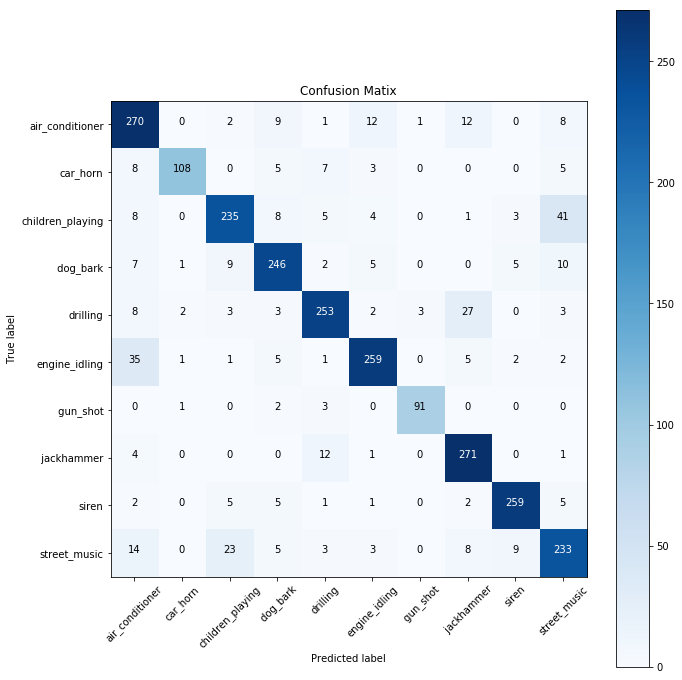

In [192]:
plot_confusion_matrix(Y_test , Y_pred)

In [193]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, Y_pred))

             precision    recall  f1-score   support

          0       0.76      0.86      0.80       315
          1       0.96      0.79      0.87       136
          2       0.85      0.77      0.81       305
          3       0.85      0.86      0.86       285
          4       0.88      0.83      0.85       304
          5       0.89      0.83      0.86       311
          6       0.96      0.94      0.95        97
          7       0.83      0.94      0.88       289
          8       0.93      0.93      0.93       280
          9       0.76      0.78      0.77       298

avg / total       0.85      0.85      0.85      2620



f1 Score is harmonic mean of precision and recall.

It conveys the balance between precision and recall.

support is number of class in validation_label.

## Neural Network 

In [208]:
import tensorflow as tf

In [209]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [210]:
n_input = 140
n_hidden_1 = 512
n_hidden_2 = 256
n_classes = 10

weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

biases = {
    'h1': tf.Variable(tf.random_normal([n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [211]:
def forward_propogation(x, weights, biases):
    in_layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['h1'])
    out_layer_1 = tf.nn.relu(in_layer_1)
    
    in_layer_2 = tf.add(tf.matmul(out_layer_1, weights['h2']), biases['h2'])
    out_layer_2 = tf.nn.relu(in_layer_2)
    
    output = tf.add(tf.matmul(out_layer_2, weights['out']), biases['out'])
    
    return output

In [212]:
x = tf.placeholder("float",[None, n_input])
y = tf.placeholder(tf.int32, [None , n_classes])
pred = forward_propogation(x, weights, biases)

In [213]:
prediction = tf.argmax(pred, axis = 1)
true_labels = tf.argmax(y, axis = 1)
correct_predictions = tf.equal(prediction, true_labels)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))

In [214]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.003)
optimize = optimizer.minimize(cost)

In [215]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [216]:
def train(x_training, y_training):
        cost_history = np.array([])
        batch_size = 32
        num_epoch = 100
        for epoch in range(num_epoch):
            num_points = x_training.shape[0]
            tot_cost = 0
            for i in range(0, num_points, batch_size):
                x_batch = x_training[i:i+batch_size]
                y_batch = y_training[i:i+batch_size]
                c, _ = sess.run([cost, optimize], feed_dict = {x : x_batch, y : y_batch})
                tot_cost += c
            cost_history = np.append(cost_history, tot_cost)
            print("Cost : ", tot_cost)
            print("Elapsed Epoch", epoch+1)
            print("-------------------------------------------------------------")
        return cost_history

In [217]:
cost_history = train(x_training=X_train , y_training=one_hot_encode(Y_train))

Cost :  111194.625389
Elapsed Epoch 1
-------------------------------------------------------------
Cost :  31645.5412273
Elapsed Epoch 2
-------------------------------------------------------------
Cost :  15439.3429949
Elapsed Epoch 3
-------------------------------------------------------------
Cost :  8118.33706513
Elapsed Epoch 4
-------------------------------------------------------------
Cost :  5039.31751542
Elapsed Epoch 5
-------------------------------------------------------------
Cost :  2873.00870305
Elapsed Epoch 6
-------------------------------------------------------------
Cost :  2143.01494855
Elapsed Epoch 7
-------------------------------------------------------------
Cost :  1159.50925616
Elapsed Epoch 8
-------------------------------------------------------------
Cost :  1277.83798646
Elapsed Epoch 9
-------------------------------------------------------------
Cost :  1263.542881
Elapsed Epoch 10
-------------------------------------------------------------
C

Cost :  281.96802178
Elapsed Epoch 83
-------------------------------------------------------------
Cost :  274.907563732
Elapsed Epoch 84
-------------------------------------------------------------
Cost :  355.720578675
Elapsed Epoch 85
-------------------------------------------------------------
Cost :  524.185759678
Elapsed Epoch 86
-------------------------------------------------------------
Cost :  397.925165857
Elapsed Epoch 87
-------------------------------------------------------------
Cost :  112.510263443
Elapsed Epoch 88
-------------------------------------------------------------
Cost :  103.260586283
Elapsed Epoch 89
-------------------------------------------------------------
Cost :  116.859951992
Elapsed Epoch 90
-------------------------------------------------------------
Cost :  80.6495638294
Elapsed Epoch 91
-------------------------------------------------------------
Cost :  112.404405853
Elapsed Epoch 92
-----------------------------------------------------

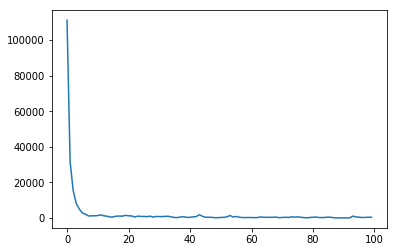

In [218]:
plt.plot(cost_history)
plt.show()

In [219]:
acc,_ = sess.run([accuracy,correct_predictions], feed_dict = {x: X_test, y: one_hot_encode(Y_test)})
acc

0.85534352

In [220]:
pred_labels = sess.run(prediction, feed_dict = {x: X_test} )

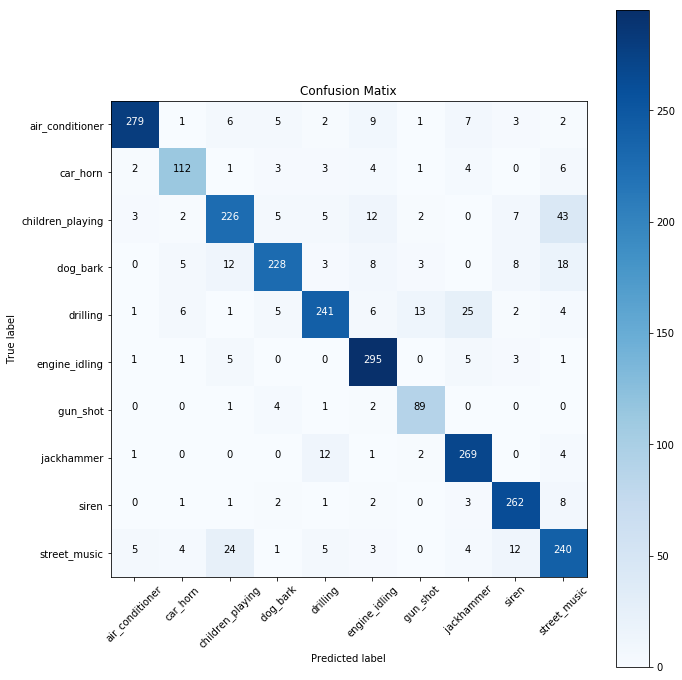

In [221]:
plot_confusion_matrix(Y_test , pred_labels)

In [222]:
print(classification_report(Y_test, pred_labels))

             precision    recall  f1-score   support

          0       0.96      0.89      0.92       315
          1       0.85      0.82      0.84       136
          2       0.82      0.74      0.78       305
          3       0.90      0.80      0.85       285
          4       0.88      0.79      0.84       304
          5       0.86      0.95      0.90       311
          6       0.80      0.92      0.86        97
          7       0.85      0.93      0.89       289
          8       0.88      0.94      0.91       280
          9       0.74      0.81      0.77       298

avg / total       0.86      0.86      0.85      2620

